In [1]:
import requests
import sys
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
import networkscience as ns
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
datasets = ['Erasmus14.csv', 'Erasmus15.csv', 'Erasmus16.csv', 'Erasmus17.csv', 'Erasmus18.csv', 'Erasmus19.csv']
local_dir = r"C:\Users\nicol\OneDrive\Desktop\scuola\NETWORK SCIENCE\progetto\data\\"

mobility_df = pd.read_csv(local_dir + datasets[5], sep=';',low_memory=False, header=0)
for i in range(1, len(datasets)):
    mobility_df = pd.concat([mobility_df, pd.read_csv(local_dir + datasets[i], sep=';',low_memory=False, header=0)], axis=0)

In [3]:
display(mobility_df)

,Project Reference,Academic Year,Mobility Start Month,Mobility End Month,Mobility Duration,Activity (mob),Field of Education,Participant Nationality,Education Level,Participant Gender,...,Participant Age,Sending Country Code,Sending City,Sending Organization,Sending Organisation Erasmus Code,Receiving Country Code,Receiving City,Receiving Organization,Receiving Organisation Erasmus Code,Participants
0,2016-3-EE01-KA105-034520,2019-2020,2019-03,2019-04,33.0,European Voluntary Service - Partner Countries,? Unknown ?,EE,??? - ? Unknown ?,Female,...,18,EE,TALLINN,MTÜ NOORTEVAHETUSE ARENGU ÜHING ESTYES,-,RU,Nizhny Novgorod,Interregional youth social movement of support...,-,1
1,2016-3-UK01-KA105-035288,2019-2020,2019-02,2019-03,56.0,European Voluntary Service - Partner Countries,? Unknown ?,IT,??? - ? Unknown ?,Male,...,29,IT,TRAPPETO,CESIE,-,UK,Cardiff,Language Academy Wales,-,1
2,2017-1-AT01-KA101-034705,2019-2020,2019-04,2019-04,6.0,Structured Courses/Training Events,Languages,AT,??? - ? Unknown ?,Female,...,39,AT,Hollabrunn,HTL Für Lebensmitteltechnologie-Lebensmittelsi...,-,EL,Heraklion,Institut für europäische Lehrerfortbildung UG ...,-,1
3,2017-1-AT01-KA101-034727,2019-2020,2019-02,2019-02,15.0,Structured Courses/Training Events,Teacher training with subject specialization,AT,??? - ? Unknown ?,Female,...,27,AT,Weiz,BHAK/BHAS Weiz,-,IE,Dublin,Atlantic Language Dublin,-,1
4,2017-1-AT01-KA101-034774,2019-2020,2019-02,2019-02,5.0,Structured Courses/Training Events,Education,AT,??? - ? Unknown ?,Female,...,26,AT,Linz,Bundesbildungsanstalt für Elementarpädagogik,-,MT,St.Julian's,Executive Training Institute Ltd.,-,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736429,2019-2-UK01-KA105-062363,2019-2020,2019-09,2019-10,7.0,Mobility of youth workers - Programme Countries,? Unknown ?,TR,??? - ? Unknown ?,Female,...,24,UK,London,YOUTH INNOVATION LTD,-,UK,London,YOUTH INNOVATION LTD,-,1
736430,2019-2-UK01-KA105-062363,2019-2020,2019-09,2019-10,7.0,Mobility of youth workers - Programme Countries,? Unknown ?,UK,??? - ? Unknown ?,Female,...,32,UK,London,YOUTH INNOVATION LTD,-,UK,London,YOUTH INNOVATION LTD,-,1
736431,2019-2-UK01-KA105-062363,2019-2020,2019-09,2019-10,7.0,Mobility of youth workers - Programme Countries,? Unknown ?,UK,??? - ? Unknown ?,Female,...,37,UK,London,YOUTH INNOVATION LTD,-,UK,London,YOUTH INNOVATION LTD,-,1
736432,2019-2-UK01-KA105-062363,2019-2020,2019-09,2019-10,7.0,Mobility of youth workers - Programme Countries,? Unknown ?,UK,??? - ? Unknown ?,Male,...,41,UK,London,YOUTH INNOVATION LTD,-,UK,London,YOUTH INNOVATION LTD,-,1


In [4]:
def filter_data(df):
    df= df[df['Participant Profile']=='Learner']
    df= df[df['Activity (mob)'].str.contains('Student')]
    df = df[~df['Activity (mob)'].str.contains('traineeship')]
    df = df.loc[:, ['Sending Organization', 'Receiving Organization', 'Participants']]
    return df

mobility_df = filter_data(mobility_df)

for index in range(len(mobility_df['Sending Organization'])):
    s_uni = mobility_df.iat[index,0]
    r_uni = mobility_df.iat[index,1]
    if s_uni != s_uni.upper():
        mobility_df.iat[index,0] = s_uni.upper()
    if r_uni != r_uni.upper():
        mobility_df.iat[index,1] = r_uni.upper()
        
display(mobility_df)

,Sending Organization,Receiving Organization,Participants
276,CHINA FOREIGN AFFAIRS UNIVERSITY,DIPLOMATISCHE AKADEMIE WIEN,1
277,FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,SOUTHERN FEDERAL UNIVERSITY,1
278,SOUTHERN FEDERAL UNIVERSITY,FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,1
279,FEDERAL STATE BUDGET EDUCATIONAL INSTITUTION O...,FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,1
280,SOUTHERN FEDERAL UNIVERSITY,FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,1
...,...,...,...
716937,UNIVERSITY COLLEGE LONDON,FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,1
716938,HEBRON UNIVERSITY,UNIVERSITY OF BRADFORD,1
716939,HEBRON UNIVERSITY,UNIVERSITY OF BRADFORD,1
716940,HEBRON UNIVERSITY,UNIVERSITY OF BRADFORD,3


In [5]:
print('Number of Receiving Universities: ',(mobility_df['Receiving Organization'].nunique()))
print('Number of Sending Universities: ',(mobility_df['Sending Organization'].nunique()))

Number of Receiving Universities:  5164
Number of Sending Universities:  6213


In [6]:
nodes = np.array(list(set.union(set(mobility_df.loc[:, 'Sending Organization']), set(mobility_df.loc[:, 'Receiving Organization']))))
node_position = {}
for i, name in enumerate(nodes):
    node_position[name] = i
nodes_df = pd.DataFrame({'Nodes': nodes})
mobility_df['SendId'] = (np.array(list(map(lambda x: node_position[x], mobility_df['Sending Organization']))))
mobility_df['RecId']= (np.array(list(map(lambda x: node_position[x], mobility_df['Receiving Organization']))))
# Adjacency matrix
adj_matrix_crs = sparse.csr_matrix((nodes.size, nodes.size),dtype=int)
adj_matrix_csc = sparse.csc_matrix((nodes.size, nodes.size),dtype=int)

In [7]:
display(nodes_df)

,Nodes
0,VALDOSTA STATE UNIVERSITY
1,GUJARAT TECHNOLOGICAL UNIVERSITY
2,SVEUCILISTE SJEVER
3,AL-HUSSEIN BIN TALAL UNIVERISTY
4,UNIVERSIDAD PONTIFICIA COMILLAS
...,...
7088,PROVIDENCE UNIVERSITY
7089,UNIVERSIDAD TÉCNICA DEL NORTE
7090,MINDANAO STATE UNIVERSITY
7091,UNIVERSITA DEGLI STUDI DELL'AQUILA


In [8]:
mobility_serie = mobility_df.groupby(['SendId', 'RecId']).sum()
row = np.array(mobility_serie.index.get_level_values(1).tolist())
col = np.array(mobility_serie.index.get_level_values(0).tolist())
val = mobility_serie.values
adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

# cercasi 70 Gb di ram, no perditempo
# ns.visualize_adj(adj_matrix_crs)

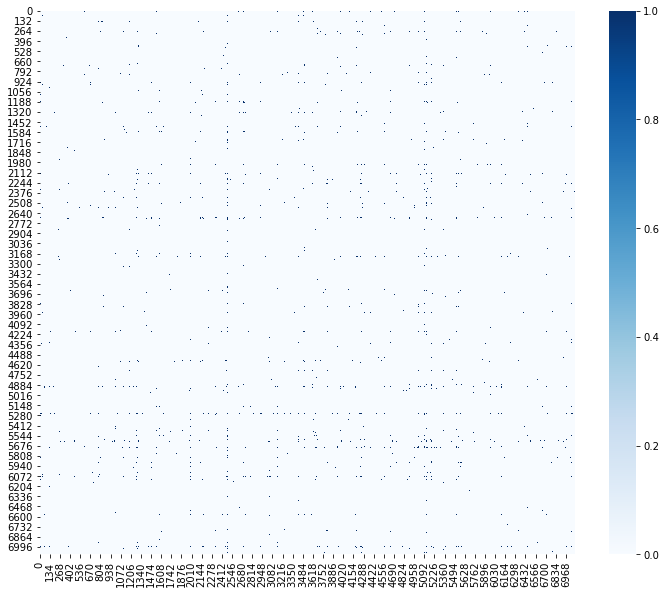

In [9]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
a_adj = adj_matrix_crs.toarray()
a_adj[a_adj>1] = 1
sns.heatmap(a_adj, cmap="Blues", ax=ax)
plt.show()

In [10]:
mobility_df.rename({'Sending Organization': 'source','Receiving Organization': 'target', 'Participants':'weight'},axis=1, inplace=True)
adj_matrix_crs, mobility_df, nodes_df = ns.keep_giant(ns.find_components(adj_matrix_crs, nodes_df), mobility_df)

### Degree distribution

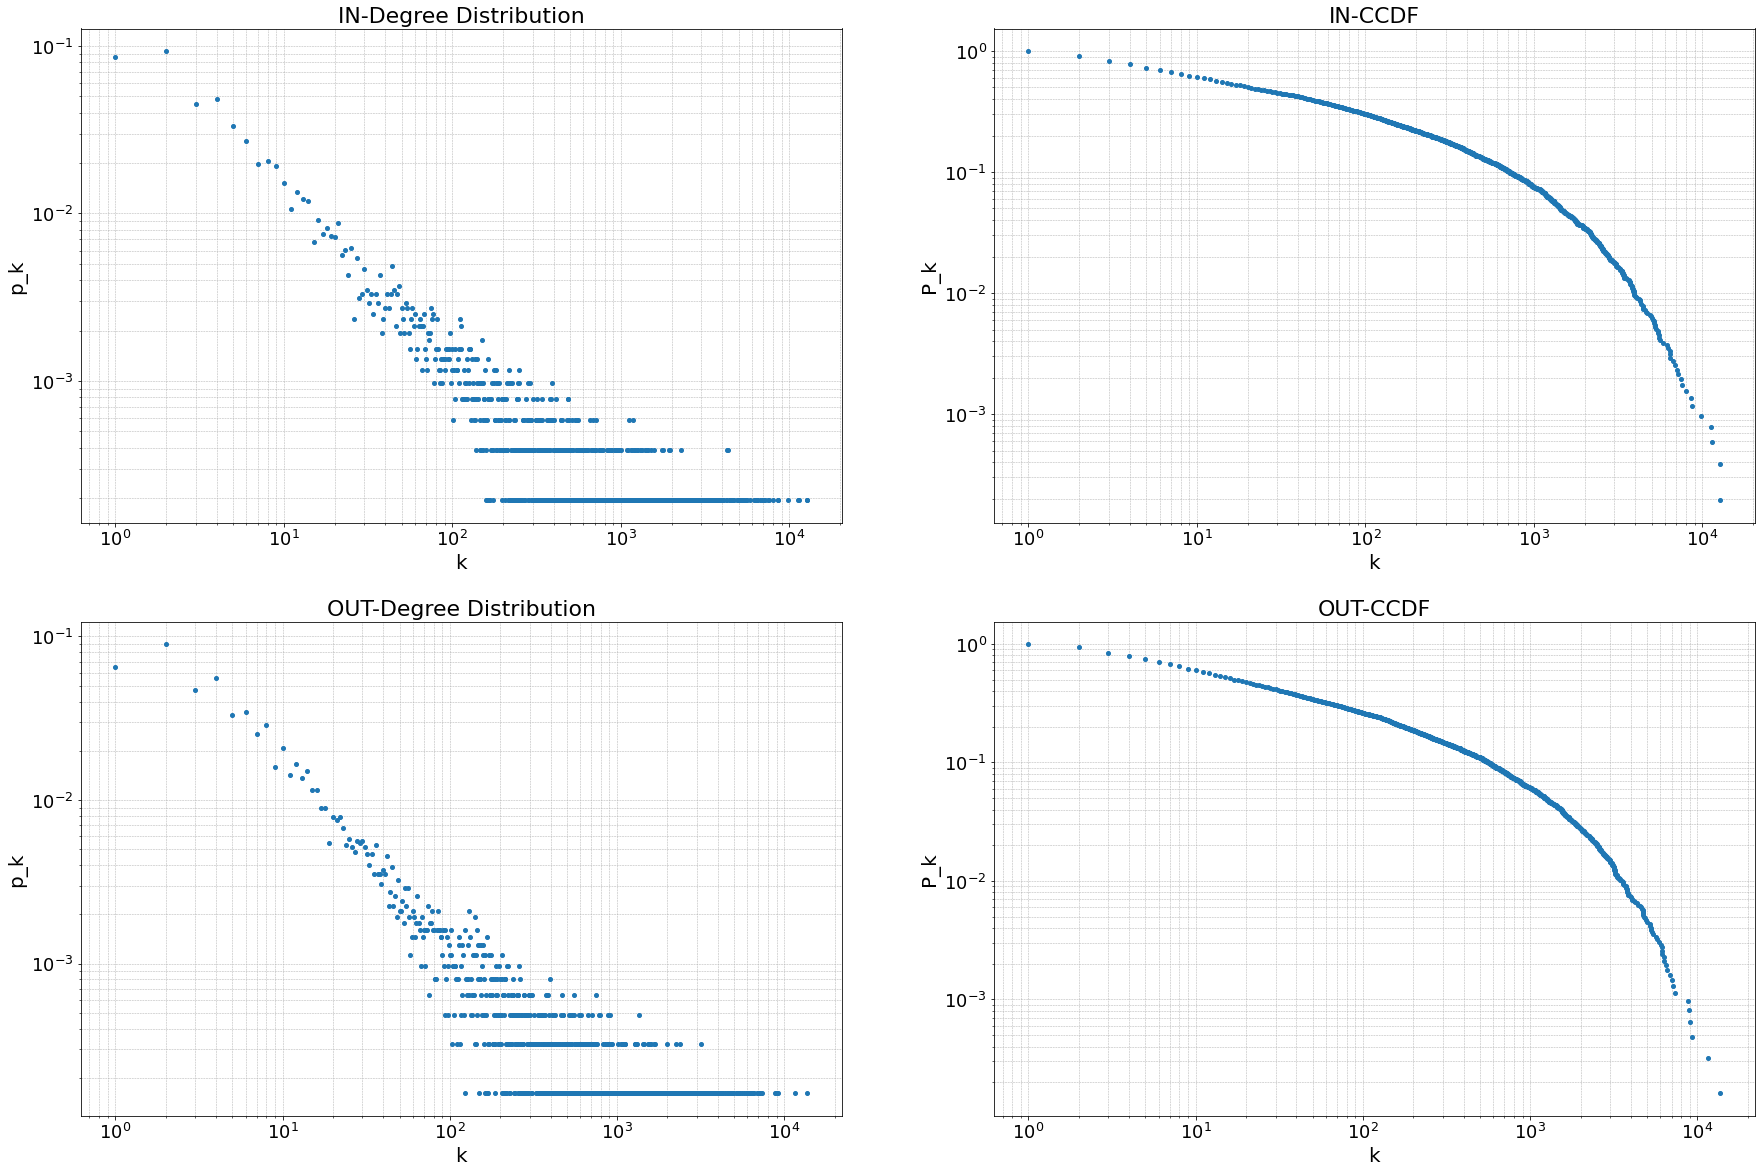

Top 10 for in degree


,Nodes,in degree
957,UNIVERSITAT DE VALENCIA,12746
2450,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,12714
4613,UNIVERSIDADE DE LISBOA,11461
2482,UNIVERSIDAD DE GRANADA,11303
1601,UNIVERSIDAD COMPLUTENSE DE MADRID,9771
3408,UNIVERSITAT POLITECNICA DE VALENCIA,8613
6513,UNIVERZA V LJUBLJANI,8540
5274,KATHOLIEKE UNIVERSITEIT LEUVEN,8039
4949,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,7595
2751,UNIVERSIDAD DE SEVILLA,7483


Top 10 for out degree


,Nodes,out degree
2450,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,13674
2482,UNIVERSIDAD DE GRANADA,11555
957,UNIVERSITAT DE VALENCIA,9220
1132,UNIVERSITA DEGLI STUDI DI PADOVA,9017
1601,UNIVERSIDAD COMPLUTENSE DE MADRID,8879
4302,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,8758
5081,UNIVERSITA DEGLI STUDI DI TORINO,7321
248,UNIVERSIDAD DEL PAIS VASCO/ EUSKAL HERRIKO UNI...,7103
5274,KATHOLIEKE UNIVERSITEIT LEUVEN,7064
4627,UNIVERSIDAD POLITECNICA DE MADRID,6834


In [11]:
scores = ns.degree_disribution(adj_matrix_crs, nodes_df, print_graph=True)
ns.display_top_n(scores, 10, 'in degree')
ns.display_top_n(scores, 10, 'out degree')

### Estimating $\gamma$ 

In [12]:
from collections import Counter
from statistics import mean

d_in = scores['in degree']
d_in = d_in[d_in>0]
d_out = scores['out degree']
d_out = d_out[d_out>0]
kmin = 100
d2_in = d_in[d_in>kmin]
d2_out = d_out[d_out>kmin]

sorted_d = sorted(d_in)
occurrence = Counter(sorted_d)
x_in = list(occurrence.keys())
y_in = list(occurrence.values())
y_in = y_in/np.sum(y_in)

sorted_d = sorted(d_out)
occurrence = Counter(sorted_d)
x_out = list(occurrence.keys())
y_out = list(occurrence.values())
y_out = y_out/np.sum(y_out)

Pk_in = 1 - np.cumsum(y_in)
Pk_in[-1] = 1 
Pk_in = sorted(Pk_in, reverse = True)
Pk_out = 1 - np.cumsum(y_out)
Pk_out[-1] = 1 
Pk_out = sorted(Pk_out, reverse = True)

In [13]:
ga_in = 1 + 1/mean(np.array(np.log(d2_in/kmin)))
ga_out = 1 + 1/mean(np.array(np.log(d2_out/kmin)))
C_in = (ga_in-1)*kmin**(ga_in-1) # normalization condition
C_out = (ga_out-1)*kmin**(ga_out-1)

pos_in = np.argmax(np.array(x_in)>=kmin)
pos_out = np.argmax(np.array(x_out)>=kmin)

P_kmin_in = Pk_in[pos_in] # constant value that shifts the line where the data are placed
pk_in = C_in*P_kmin_in*x_in**-ga_in
Pk_est_in = C_in*P_kmin_in*x_in**(-(ga_in-1))/(ga_in-1) 

P_kmin_out = Pk_out[pos_out] # constant value that shifts the line where the data are placed
pk_out = C_out*P_kmin_out*x_out**-ga_out
Pk_est_out = C_out*P_kmin_out*x_out**(-(ga_out-1))/(ga_out-1) 

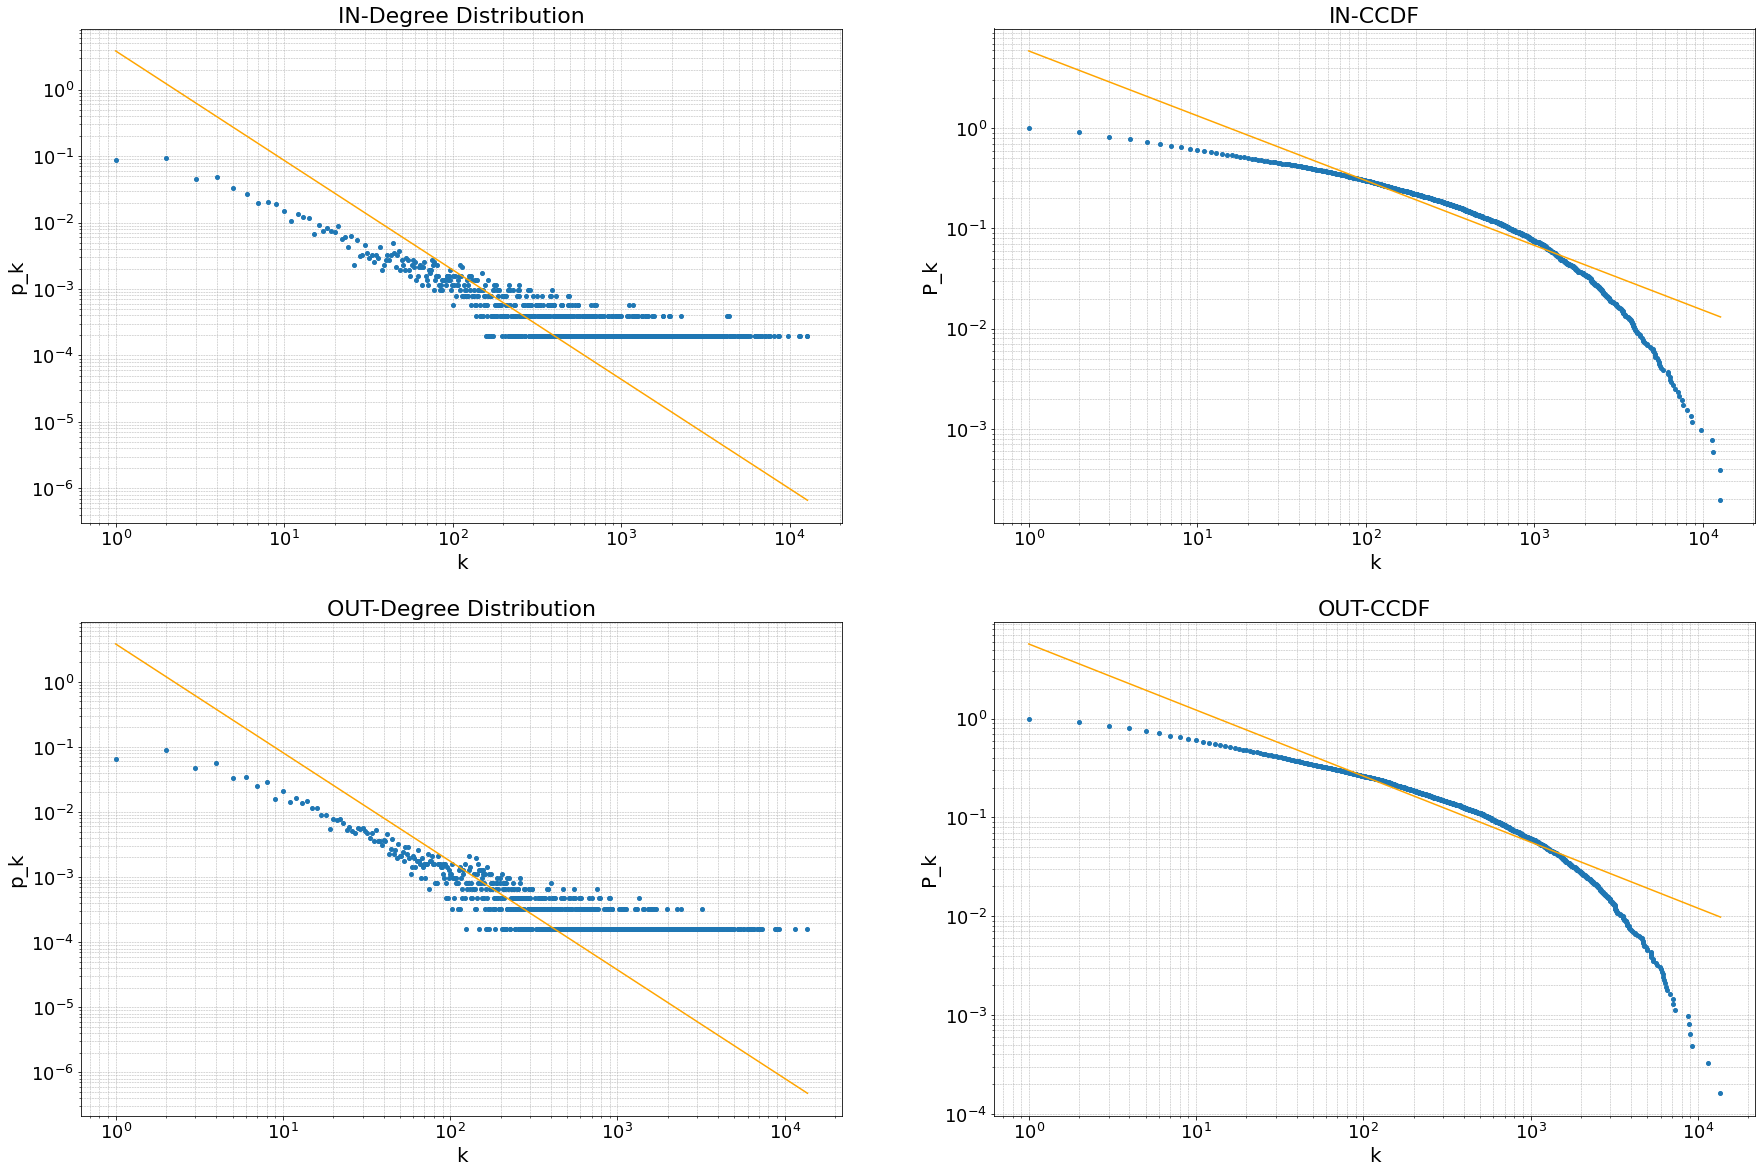

In [14]:
fig, ax = plt.subplots(2, 2, figsize = (30, 20))

def plot_gamma(ax, x, y, title, p, cumulative=False):
    ax.loglog(x, y, 'o', markersize = 4)
    ax.loglog(x, p, color='orange')
    ax.grid(which='both', linestyle='--', linewidth=0.5)
    ax.set_title(title, size = 22)
    ax.set_xlabel("k", size = 20)
    if cumulative:
        ax.set_ylabel("P_k", size = 20)
    else:
        ax.set_ylabel("p_k", size = 20)
    ax.tick_params(labelsize=18)
    ax.tick_params(labelsize=18)

plot_gamma(ax[0,0], x_in, y_in, "IN-Degree Distribution", pk_in)
plot_gamma(ax[0,1], x_in, Pk_in, "IN-CCDF", Pk_est_in, True)
plot_gamma(ax[1,0], x_out, y_out, "OUT-Degree Distribution", pk_out)
plot_gamma(ax[1,1], x_out, Pk_out, "OUT-CCDF", Pk_est_out, True)
plt.show()

### Estimating $\gamma$ through a linear fit with log binning

In [15]:
# Log binning 
nbins = 20
bins = np.logspace(0, 3.3, nbins)

hist_in = np.histogram(d_in, bins=bins, density=True)
hist_out = np.histogram(d_out, bins=bins, density=True)
logbin_p_k_in = hist_in[0]
logbin_p_k_out = hist_out[0]
middle_bins = np.sqrt( np.delete(bins, 0) * np.delete(bins, nbins-1) )

mask = np.log10(middle_bins) > np.log10(kmin)
x = np.log10( middle_bins[mask] )
y_in = np.log10( logbin_p_k_in[mask] )
y_out = np.log10( logbin_p_k_out[mask] )

# Linear fit
params_in = np.polyfit(x, y_in, deg =1)
params_out = np.polyfit(x, y_out, deg =1)
lin_gamma_in = -params_in[0]
lin_gamma_out = -params_out[0]

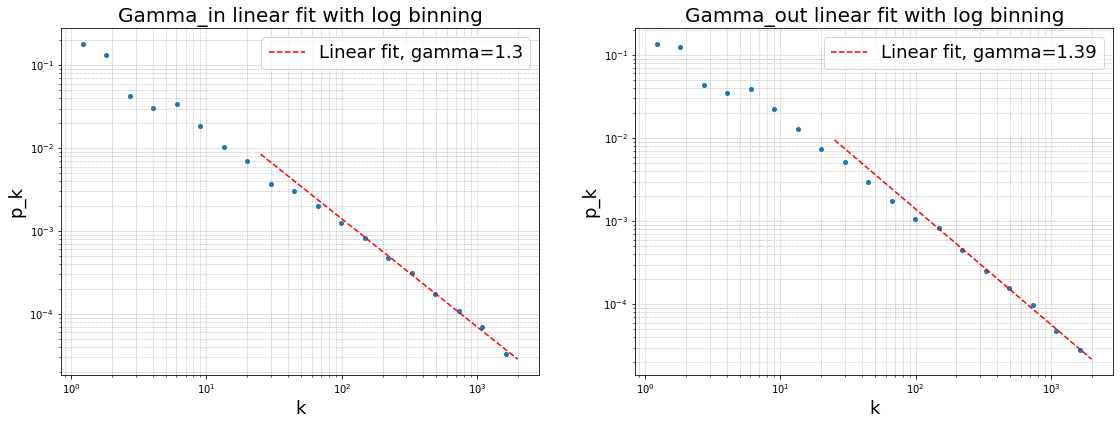

In [16]:
plt.figure(figsize=(60, 60))
plt.subplot(8, 6, 1)
plt.loglog(middle_bins, logbin_p_k_in , 'o', markersize = 4)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title("Gamma_in linear fit with log binning", size = 20)
plt.xlabel("k", size = 18)
plt.ylabel("p_k", size = 18)
x2 = np.logspace(1.4,3.3,100)
y2 = np.full( 100, 10**(params_in[1])*x2**(-lin_gamma_in) ) 
plt.plot(x2,y2, label ="Linear fit, gamma="+str( np.round(lin_gamma_in,2) ), color="red", linestyle="--")
plt.legend(fontsize=18)

plt.subplot(8, 6, 2)
plt.loglog(middle_bins, logbin_p_k_out , 'o', markersize = 4)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title("Gamma_out linear fit with log binning", size = 20)
plt.xlabel("k", size = 18)
plt.ylabel("p_k", size = 18)
x2 = np.logspace(1.4,3.3,100)
y2 = np.full( 100, 10**(params_out[1])*x2**(-lin_gamma_out) ) 
plt.plot(x2,y2, label ="Linear fit, gamma="+str( np.round(lin_gamma_out,2) ), color="red", linestyle="--")
plt.legend(fontsize=18)

plt.show()

### HITS (NetworkX)

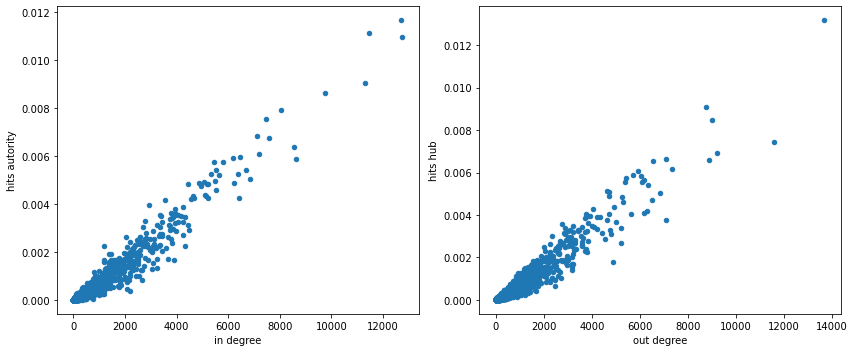

Top 10 for hits hub


,Nodes,hits hub
2450,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.013172
4302,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.009075
1132,UNIVERSITA DEGLI STUDI DI PADOVA,0.008461
2482,UNIVERSIDAD DE GRANADA,0.007461
957,UNIVERSITAT DE VALENCIA,0.006940
5274,KATHOLIEKE UNIVERSITEIT LEUVEN,0.006626
1601,UNIVERSIDAD COMPLUTENSE DE MADRID,0.006589
4613,UNIVERSIDADE DE LISBOA,0.006522
5081,UNIVERSITA DEGLI STUDI DI TORINO,0.006159
1371,TECHNISCHE UNIVERSITAET MUENCHEN,0.006090


Top 10 for hits autority


,Nodes,hits autority
2450,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.011659
4613,UNIVERSIDADE DE LISBOA,0.011132
957,UNIVERSITAT DE VALENCIA,0.010968
2482,UNIVERSIDAD DE GRANADA,0.009055
1601,UNIVERSIDAD COMPLUTENSE DE MADRID,0.008639
5274,KATHOLIEKE UNIVERSITEIT LEUVEN,0.007915
2751,UNIVERSIDAD DE SEVILLA,0.007545
4603,UNIVERSITAT DE BARCELONA,0.006844
4949,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,0.006759
6513,UNIVERZA V LJUBLJANI,0.006364


In [17]:
df = ns.hits_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'hits hub')
ns.display_top_n(scores, 10, 'hits autority')

### PageRank (NetworkX)

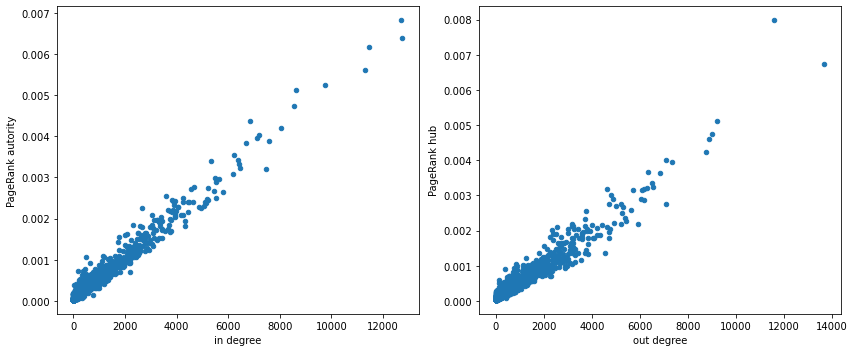

Top 10 for PageRank hub


,Nodes,PageRank hub
2482,UNIVERSIDAD DE GRANADA,0.007980
2450,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.006743
957,UNIVERSITAT DE VALENCIA,0.005123
1132,UNIVERSITA DEGLI STUDI DI PADOVA,0.004736
1601,UNIVERSIDAD COMPLUTENSE DE MADRID,0.004617
4302,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.004247
248,UNIVERSIDAD DEL PAIS VASCO/ EUSKAL HERRIKO UNI...,0.004012
5081,UNIVERSITA DEGLI STUDI DI TORINO,0.003941
6513,UNIVERZA V LJUBLJANI,0.003671
4627,UNIVERSIDAD POLITECNICA DE MADRID,0.003627


Top 10 for PageRank autority


,Nodes,PageRank autority
2450,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.006816
957,UNIVERSITAT DE VALENCIA,0.006393
4613,UNIVERSIDADE DE LISBOA,0.006160
2482,UNIVERSIDAD DE GRANADA,0.005618
1601,UNIVERSIDAD COMPLUTENSE DE MADRID,0.005240
3408,UNIVERSITAT POLITECNICA DE VALENCIA,0.005124
6513,UNIVERZA V LJUBLJANI,0.004727
2208,POLITECNICO DI MILANO,0.004376
5274,KATHOLIEKE UNIVERSITEIT LEUVEN,0.004191
4302,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.004040


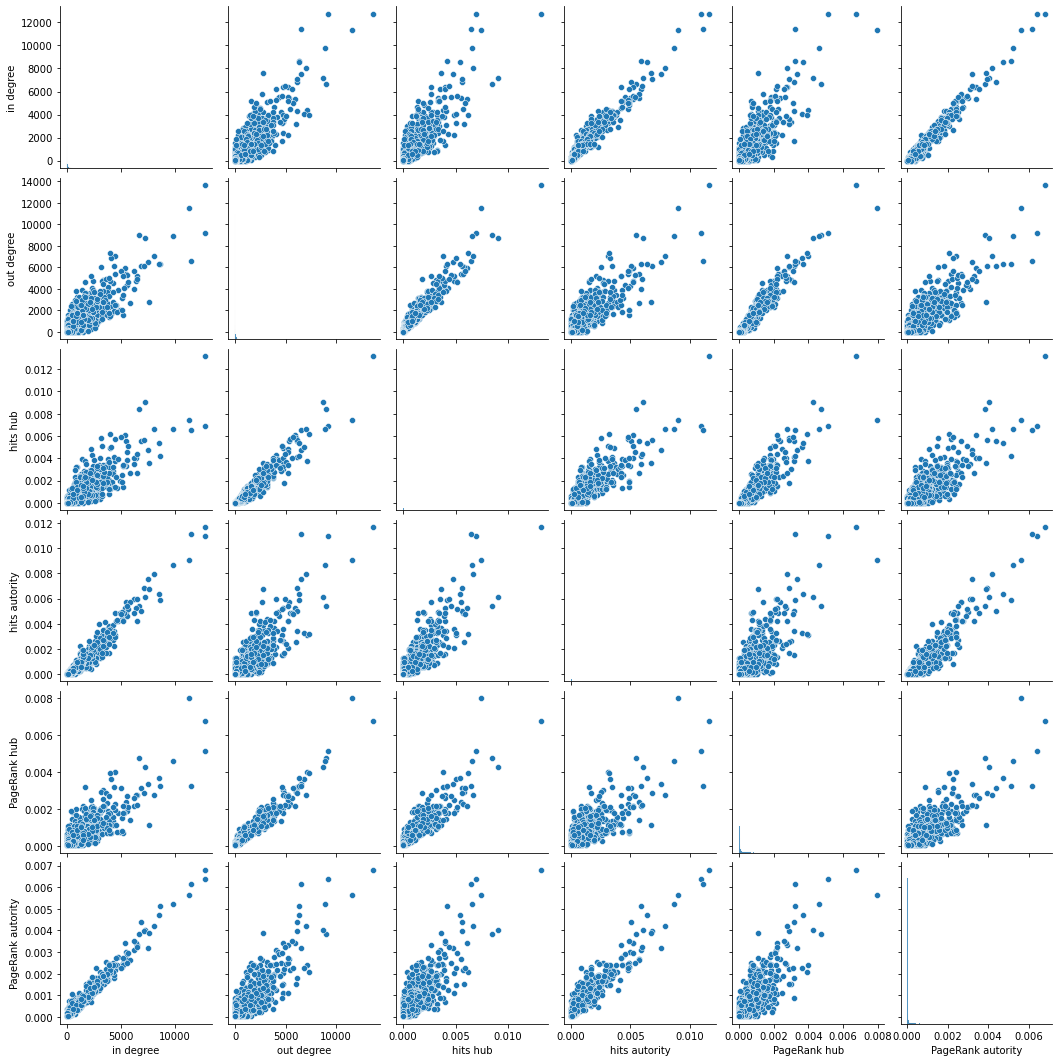

In [18]:
df = ns.pagerank_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'PageRank hub')
ns.display_top_n(scores, 10, 'PageRank autority')
# ci vuole troppo a farlo
sns.pairplot(scores[['in degree', 'out degree',  'hits hub',
       'hits autority', 'PageRank hub', 'PageRank autority']])
plt.show()
# from IPython.display import Image
# Image('pairplot_score.png',)

### Assortativity

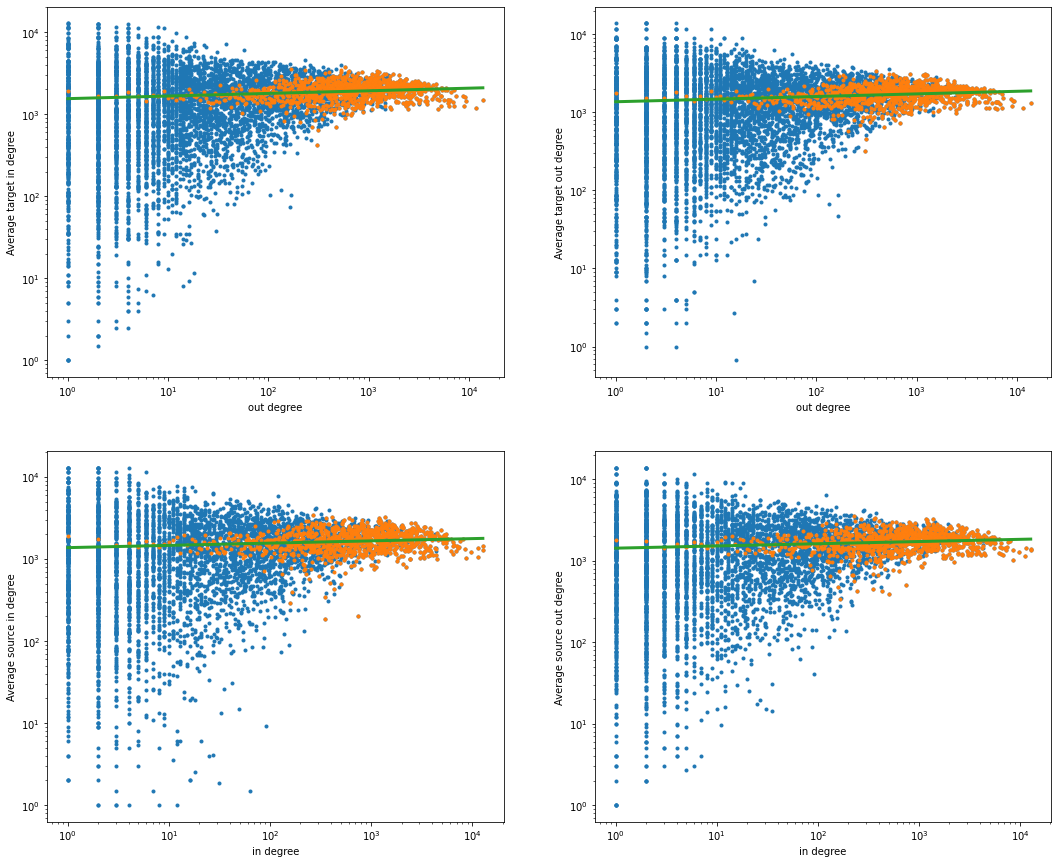

(0.031892977861909234,
 0.03350709967863511,
 0.027473147656077748,
 0.02710686470732852)

In [19]:
edges = mobility_df.copy()
ns.assortativity_calc(edges, adj_matrix_crs, nodes_df, True)

### Robustness

In [20]:
#attack: removing hubs first
nodes_byhub = scores.sort_values('PageRank hub', ascending=False)['NodeID']
indices = list(nodes_byhub)
uni_df = mobility_df.copy()
GC_frac_a = [1]
for node in indices:
    uni_df = uni_df.loc[(uni_df['sourceID'] != node) & (uni_df['targetID'] != node)]
    temp_serie = uni_df.groupby(['sourceID', 'targetID']).sum()
    row = np.array(temp_serie.index.get_level_values(1).tolist())
    col = np.array(temp_serie.index.get_level_values(0).tolist())
    val = temp_serie.values
    temp_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
    GC_frac_a.append(ns.fraction_in_giant(temp_adj))


In [ ]:
#random node removal
import random
#10 by 10, with average over 10 trials each time
intervals = list(range(10, len(nodes_byhub+1), 10))
uni_df = mobility_df.copy()
GC_frac_r = [1]
for i in intervals:
    i_GC_frac = []
    for j in range(10):
        removed = random.sample(indices, i)
        temp_df = uni_df.loc[~(uni_df['sourceID'].isin(removed) | (uni_df['targetID'].isin(removed)))]
        temp_serie = temp_df.groupby(['sourceID', 'targetID']).sum()
        row = np.array(temp_serie.index.get_level_values(1).tolist())
        col = np.array(temp_serie.index.get_level_values(0).tolist())
        val = temp_serie.values
        temp_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
        i_GC_frac.append(ns.fraction_in_giant(temp_adj))
    GC_frac_r.append(sum(i_GC_frac)/10)

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.plot([i/len(nodes_byhub) for i in range(len(nodes_byhub)+1)], GC_frac_a, label='Targeted attack')
plt.plot([0]+[i/(len(intervals)*10) for i in intervals], GC_frac_r, 'r', label='Random node removal')
plt.plot([0,1], [1,0], 'g', label='linear reference')
plt.xlabel('Fraction of nodes in the giant component', size=14)
plt.ylabel('Fraction of removed nodes', size=14)
plt.title('Robustness', size=20)
plt.legend(fontsize=16)
plt.show()